___
# Ioannou_Georgios


## Copyright © 2023 by Georgios Ioannou


___
<h1 align="center"> Facial Expression Recognition on Video and Image </h1>
<h2 align="center"> Facial Expression Recognition </h2>

In this notebook, we will be classifying emotion based on facial expression. The datasets we will be using are called:
1. [`FER2013`](https://www.kaggle.com/datasets/deadskull7/fer2013)
2. [`The Extended Cohn-Kanade Dataset (CK+)`](https://www.kaggle.com/datasets/davilsena/ckdataset)


___
<h2 align="center"> Remember our main steps motto "ISBE" </h2>

<h3 align="center"> Main Steps when building a Machine Learning Model </h3>

1. **I** - `Inspect and explore data`
2. **S** - `Select and engineer features`
3. **B** - `Build and train model`
4. **E** - `Evaluate model`


___
<h2 align="center"> Libraries </h2>


In [1]:
# Import libraries.

# Use inline so our visualizations display in notebook.


%matplotlib inline


import matplotlib.pyplot as plt   # Data visualization.
import numpy as np                # Data wrangling.
import os                         # Manipulate operating system interfaces.
import pandas as pd               # Data handling.
import pickle                     # Python object serialization.
import plotly.express as px       # Data visualization
import plotly.graph_objects as go # Data visualization
import seaborn as sns             # Data visualization.
sns.set()
import warnings                   # Ignore all warnings.
warnings.filterwarnings("ignore")


from imblearn.over_sampling import RandomOverSampler     # Perform random over-sampling.
from keras.utils.np_utils import to_categorical          # Convert a class vector (integers) to binary class matrix.
from PIL import Image
from sklearn.preprocessing import StandardScaler         # To perform standardization by centering and scaling.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split     # To split data in training/validating/testing.
from statistics import mode                              # Find the most likely predicted emotion.
from tensorflow.keras import models                      # Group layers into an object with training and inference features.
from tensorflow.keras import layers                      # Keras layers API.
from tensorflow.keras import Input                       # Keras Input API. Instantiate a Keras tensor.
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.optimizers import Adam             # Adam optimizer.
from tensorflow.keras.models import load_model           # To load the model.
from tensorflow.keras.utils import plot_model            # Visualize the model and save it.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


___
## #1 Inspect and Explore Data


## 1.1 Import Datasets Paths


In [2]:
FER_2013_PATH = "../input/fer2013/fer2013.csv"
CK_PATH = "../input/ckdataset/ckextended.csv"


## 1.2 Explore the Data of the FER2013 Dataset


In [3]:
fer_2013_df = pd.read_csv(FER_2013_PATH)

print("fer_2013_df.shape=", fer_2013_df.shape, "\n")
print("Unique emotions = ", sorted(fer_2013_df["emotion"].unique()), "\n")
print("# of Unique emotions = ", len(fer_2013_df["emotion"].unique()), "\n")
print(fer_2013_df.emotion.value_counts(), "\n")

print("Unique Usage = ", sorted(fer_2013_df["Usage"].unique()), "\n")
print("# of Unique Usage = ", len(fer_2013_df["Usage"].unique()), "\n")
print(fer_2013_df.Usage.value_counts(), "\n")

print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")

fer_2013_df


fer_2013_df.shape= (35887, 3) 

Unique emotions =  [0, 1, 2, 3, 4, 5, 6] 

# of Unique emotions =  7 

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64 

Unique Usage =  ['PrivateTest', 'PublicTest', 'Training'] 

# of Unique Usage =  3 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64 

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
# Create a mapping dictionary to match the integer values to a string of emotion.

emotions_classes_dict = {0 : "Angry",
                         1 : "Disgust",
                         2 : "Fear",
                         3 : "Happy",
                         4 : "Sad",
                         5 : "Surprise",
                         6 : "Neutral"}

# Map the integer values to their corresponding emotion labels.

fer_2013_df["emotion_label"] = fer_2013_df["emotion"].map(emotions_classes_dict)

fer_2013_df


,emotion,pixels,Usage,emotion_label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral
...,...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,Neutral
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest,Happy
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest,Angry
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest,Happy


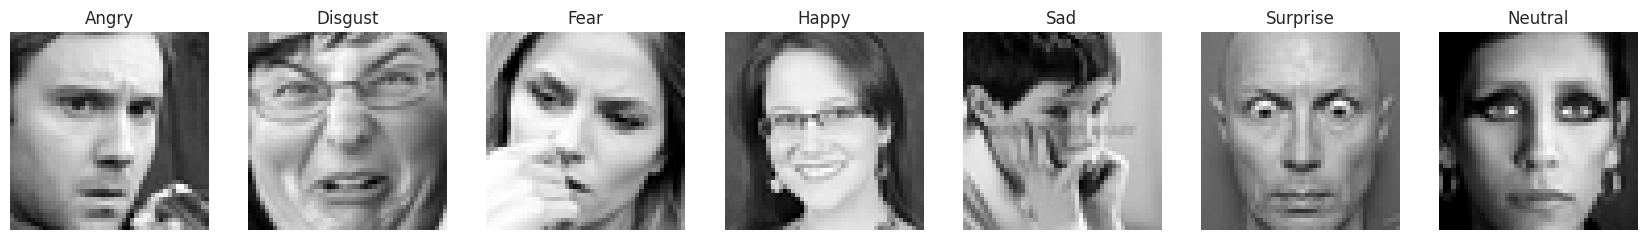

In [5]:
# Visualize a picture for each and every emotion.

def string_to_array(pixel_string, width, height):
    pixel_values = [int(x) for x in pixel_string.split()]
    return np.array(pixel_values).reshape(height, width)


def display_images(df):
    emotions = df["emotion"].unique()
    fig, axes = plt.subplots(1, len(emotions), figsize=(len(emotions) * 3, 3))

    for emotion, ax in zip(emotions, axes):
        emotion_df = df[df["emotion"] == emotion]
        pixel_string = emotion_df.iloc[0]["pixels"]
        image_array = string_to_array(pixel_string, 48, 48)
        ax.imshow(image_array, cmap="gray")
        ax.set_title(emotion)
        ax.axis("off")

    plt.show()

    
tmp_data = {
    "emotion": ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    "pixels": [
        fer_2013_df["pixels"][0],
        fer_2013_df["pixels"][299],
        fer_2013_df["pixels"][2],
        fer_2013_df["pixels"][7],
        fer_2013_df["pixels"][3],
        fer_2013_df["pixels"][15],
        fer_2013_df["pixels"][4],
    ],
}

tmp_df = pd.DataFrame(tmp_data)

display_images(tmp_df)


## 1.3 Explore the Data of the The Extended Cohn-Kanade Dataset (CK+)


In [6]:
ck_df = pd.read_csv(CK_PATH)

# Remove the Contempt emotion.

ck_df = ck_df.loc[ck_df["emotion"] != 7]

print("ck_df.shape=", ck_df.shape, "\n")
print("Unique emotions = ", sorted(ck_df["emotion"].unique()), "\n")
print("# of Unique emotions = ", len(ck_df["emotion"].unique()), "\n")
print(ck_df.emotion.value_counts(), "\n")

print("Unique Usage = ", sorted(ck_df["Usage"].unique()), "\n")
print("# of Unique Usage = ", len(ck_df["Usage"].unique()), "\n")
print(ck_df.Usage.value_counts(), "\n")

print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")

ck_df


ck_df.shape= (902, 3) 

Unique emotions =  [0, 1, 2, 3, 4, 5, 6] 

# of Unique emotions =  7 

6    593
5     83
3     69
1     59
0     45
4     28
2     25
Name: emotion, dtype: int64 

Unique Usage =  ['PrivateTest', 'PublicTest', 'Training'] 

# of Unique Usage =  3 

Training       720
PrivateTest     93
PublicTest      89
Name: Usage, dtype: int64 

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


In [7]:
# Match the integer values to a string of emotion using the emotions_classes_dict mapping dictionary.
# Map the integer values to their corresponding emotion labels.

ck_df["emotion_label"] = ck_df["emotion"].map(emotions_classes_dict)

ck_df


,emotion,pixels,Usage,emotion_label
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training,Neutral
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training,Neutral
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training,Neutral
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training,Neutral
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training,Neutral
...,...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest,Surprise
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest,Surprise
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest,Surprise
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest,Surprise


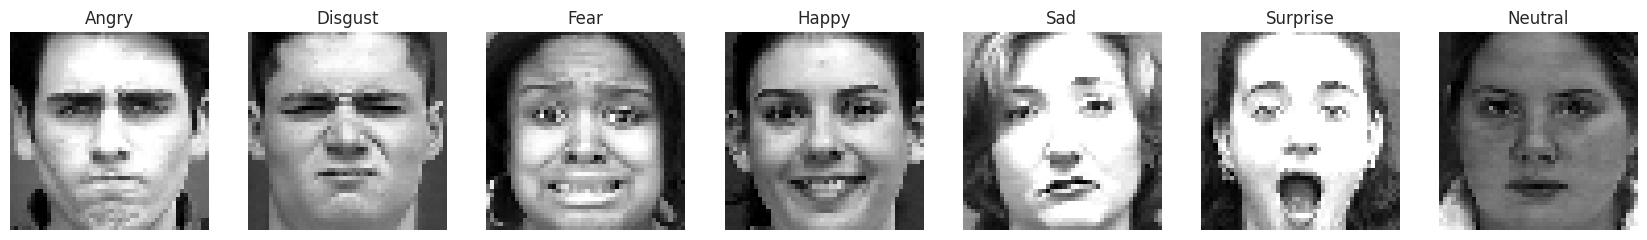

In [8]:
# Visualize a picture for each and every emotion.

tmp_data = {
    "emotion": ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    "pixels": [
        ck_df["pixels"][680],
        ck_df["pixels"][725],
        ck_df["pixels"][812],
        ck_df["pixels"][593],
        ck_df["pixels"][784],
        ck_df["pixels"][837],
        ck_df["pixels"][0],
    ],
}

tmp_df = pd.DataFrame(tmp_data)

display_images(tmp_df)


## 1.4 Combine the Two Datasets


In [9]:
combined_df = pd.concat([fer_2013_df, ck_df],axis=0)

print('combined_df.shape=', combined_df.shape, '\n')

print('Unique emotions = ', sorted(combined_df['emotion'].unique()), '\n')
print('# of Unique emotions = ', len(combined_df['emotion'].unique()), '\n')
print(combined_df.emotion.value_counts(), "\n")

print('Unique emotions = ', sorted(combined_df['emotion_label'].unique()), '\n')
print('# of Unique emotions = ', len(combined_df['emotion_label'].unique()), '\n')
print(combined_df.emotion_label.value_counts(), "\n")

print("Unique Usage = ", sorted(combined_df["Usage"].unique()), "\n")
print("# of Unique Usage = ", len(fer_2013_df["Usage"].unique()), "\n")
print(fer_2013_df.Usage.value_counts(), "\n")

print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")

combined_df


combined_df.shape= (36789, 4) 

Unique emotions =  [0, 1, 2, 3, 4, 5, 6] 

# of Unique emotions =  7 

3    9058
6    6791
4    6105
2    5146
0    4998
5    4085
1     606
Name: emotion, dtype: int64 

Unique emotions =  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] 

# of Unique emotions =  7 

Happy       9058
Neutral     6791
Sad         6105
Fear        5146
Angry       4998
Surprise    4085
Disgust      606
Name: emotion_label, dtype: int64 

Unique Usage =  ['PrivateTest', 'PublicTest', 'Training'] 

# of Unique Usage =  3 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64 

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



,emotion,pixels,Usage,emotion_label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral
...,...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest,Surprise
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest,Surprise
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest,Surprise
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest,Surprise


## 1.5 Visualize the Training and Testing Data of the Combined Dataset


In [10]:
# List the distribution of each emotion used for TPrivate Test, Public Test, and Training.

emotion_counts_by_usage  = combined_df.groupby(["Usage", "emotion"]).size().reset_index(name="Count")

# Map the integer values to their corresponding emotion labels.

emotion_counts_by_usage["emotion_label"] = emotion_counts_by_usage["emotion"].map(emotions_classes_dict)

emotion_counts_by_usage


,Usage,emotion,Count,emotion_label
0,PrivateTest,0,496,Angry
1,PrivateTest,1,61,Disgust
2,PrivateTest,2,531,Fear
3,PrivateTest,3,886,Happy
4,PrivateTest,4,597,Sad
5,PrivateTest,5,425,Surprise
6,PrivateTest,6,686,Neutral
7,PublicTest,0,471,Angry
8,PublicTest,1,62,Disgust
9,PublicTest,2,498,Fear


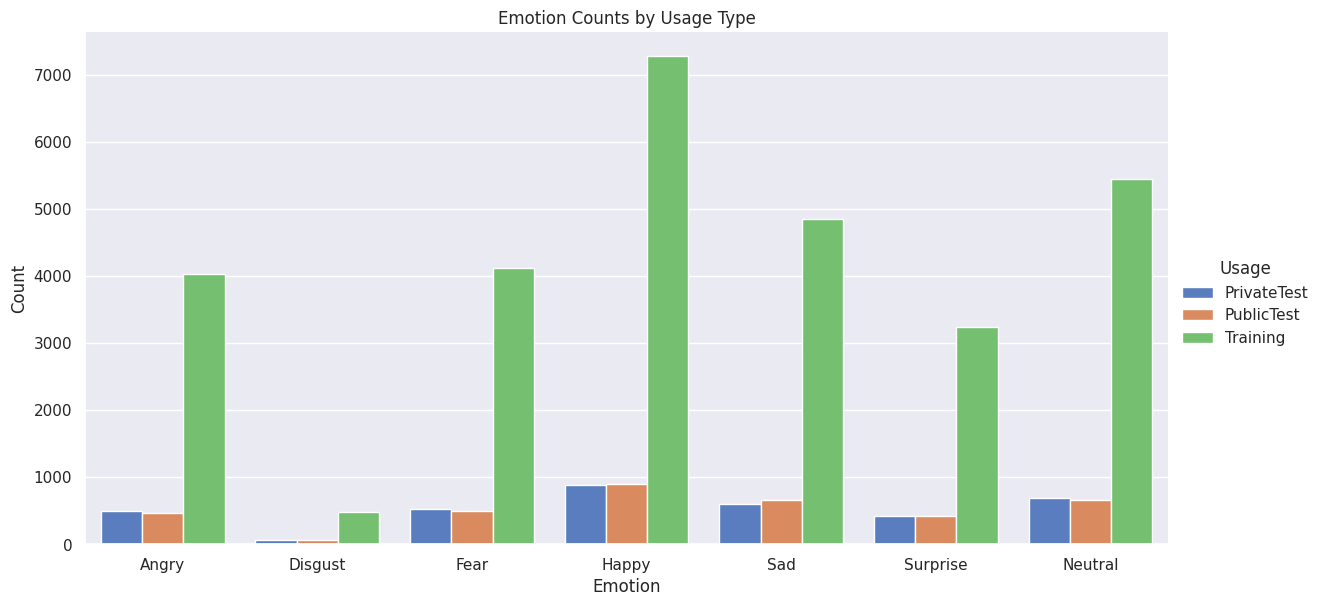

In [11]:
# Create the countplot with the emotion labels as the x-axis and Usage as the hue.

g = sns.catplot(data=emotion_counts_by_usage, x="emotion", y="Count", hue="Usage", kind="bar", palette="muted", height=6, aspect=2)

# Set the x-axis labels to emotion labels using the emotions_classes_dict.

g.set_xticklabels([emotions_classes_dict[int(t.get_text())] for t in g.ax.get_xticklabels()])

# Set axis labels and title.

g.set_axis_labels("Emotion", "Count")
g.ax.set_title("Emotion Counts by Usage Type")

plt.show()


In [12]:
# Create separate dataframes for each Usage.

data = []

for usage in emotion_counts_by_usage["Usage"].unique():
    df_usage = emotion_counts_by_usage[emotion_counts_by_usage["Usage"] == usage]
    trace = go.Bar(x=[emotions_classes_dict[emotion] for emotion in df_usage["emotion"]], y=df_usage["Count"], name=usage)
    data.append(trace)

# Create layout.

layout = go.Layout(title="Emotion Counts by Usage Type",
                   xaxis=dict(title="Emotion"),
                   yaxis=dict(title="Count"),
                   legend=dict(x=1.0, y=1.0),
                   barmode="group")

# Create a figure with all prepared data for the plot.

fig = go.Figure(data=data, layout=layout)

fig.show()


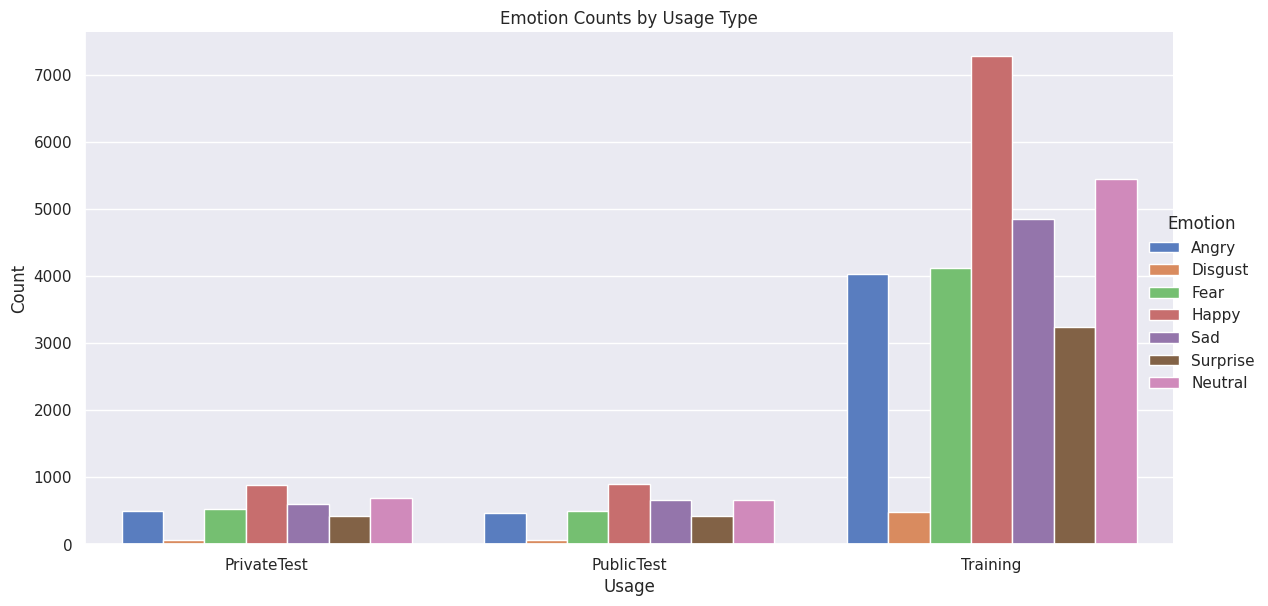

In [13]:
# Create the countplot with the usage as the x-axis and emotion as the hue.

g = sns.catplot(data=emotion_counts_by_usage, x="Usage", y="Count", hue="emotion", kind="bar", palette="muted", height=6, aspect=2)

# Set the hue labels to emotion labels using the emotions_classes_dict.

g.legend.set_title("Emotion")

for t, l in zip(g.legend.texts, emotions_classes_dict.values()):
    t.set_text(l)

# Set axis labels and title.

g.set_axis_labels("Usage", "Count")
g.ax.set_title("Emotion Counts by Usage Type")

plt.show()


In [14]:
# Create two separate dataframes for each emotion.

data = []

for emotion in emotions_classes_dict.keys():
    df_emotion = emotion_counts_by_usage[emotion_counts_by_usage["emotion"] == emotion]
    trace = go.Bar(x=df_emotion["Usage"], y=df_emotion["Count"], name=emotions_classes_dict[emotion])
    data.append(trace)

# Create layout.

layout = go.Layout(title="Emotion Counts by Usage Type",
                   xaxis=dict(title="Usage"),
                   yaxis=dict(title="Count"),
                   legend=dict(x=1.0, y=1.0),
                   barmode="group")

# Create a figure with all prepared data for the plot.

fig = go.Figure(data=data, layout=layout)

fig.show()


## 1.6 Inspect / Remove NULL Values


In [15]:
print(combined_df.isnull().sum(), "\n")
print("combined_df.isnull().sum().sum() = ", combined_df.isnull().sum().sum())


emotion          0
pixels           0
Usage            0
emotion_label    0
dtype: int64 

combined_df.isnull().sum().sum() =  0


## 1.7 Print Out The Number Examples in Each Class (aka the class balances)


In [16]:
combined_df.emotion.value_counts(), combined_df.emotion.value_counts(normalize=True)


(3    9058
 6    6791
 4    6105
 2    5146
 0    4998
 5    4085
 1     606
 Name: emotion, dtype: int64,
 3    0.246215
 6    0.184593
 4    0.165946
 2    0.139879
 0    0.135856
 5    0.111039
 1    0.016472
 Name: emotion, dtype: float64)

In [17]:
combined_df.emotion_label.value_counts(), combined_df.emotion_label.value_counts(normalize=True)


(Happy       9058
 Neutral     6791
 Sad         6105
 Fear        5146
 Angry       4998
 Surprise    4085
 Disgust      606
 Name: emotion_label, dtype: int64,
 Happy       0.246215
 Neutral     0.184593
 Sad         0.165946
 Fear        0.139879
 Angry       0.135856
 Surprise    0.111039
 Disgust     0.016472
 Name: emotion_label, dtype: float64)

## 1.8 Print Out the Number of Unique Emotions


In [18]:
emotions_classes = sorted(combined_df["emotion"].unique())
emotions_classes_label = sorted(combined_df["emotion_label"].unique())

print(emotions_classes, "\n")
print(emotions_classes_label, "\n")
print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral")


[0, 1, 2, 3, 4, 5, 6] 

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] 

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


## 1.9 Bar Chart and Pie Chart of the Unique Emotions


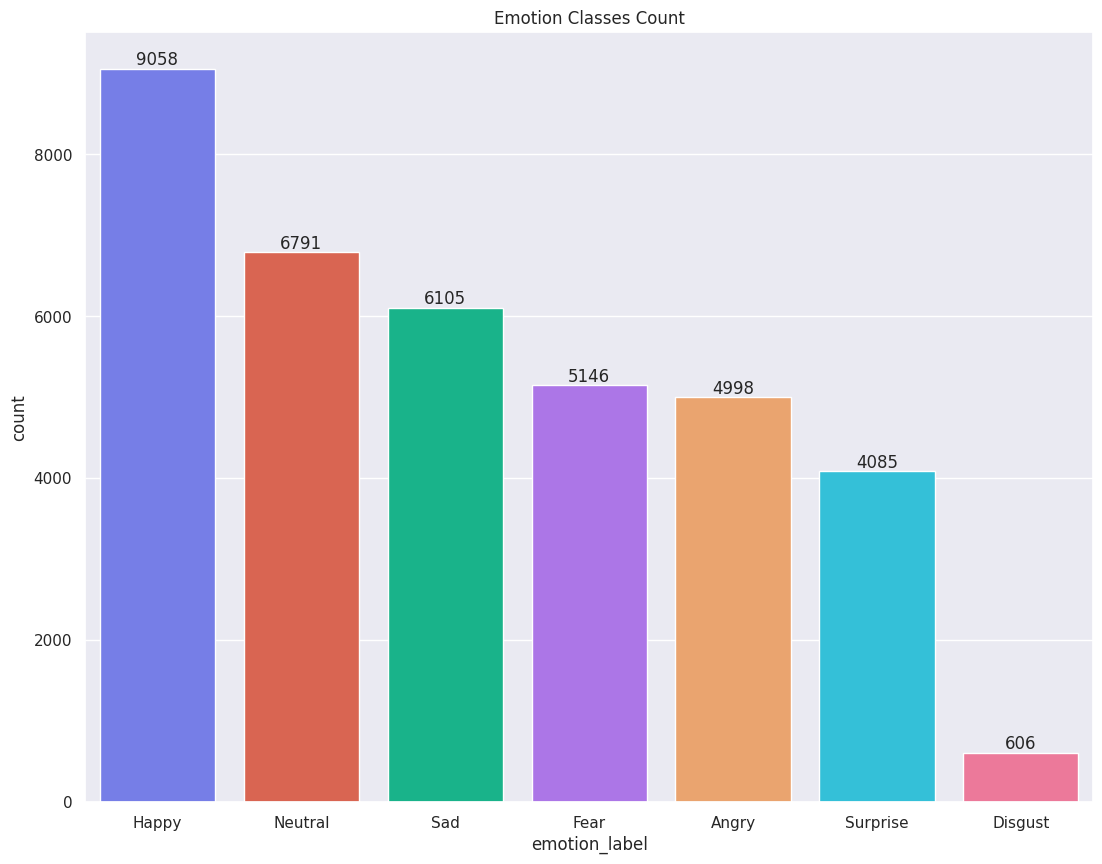

In [19]:
plt.figure(figsize = (13,10))
plt.title("Emotion Classes Count")
ax = sns.countplot(data = combined_df, x = "emotion_label", order = combined_df["emotion_label"].value_counts().index, palette = ["#636efa", "#ef553b", "#00cc96", "#ab63fa", "#ffa15a", "#19d3f3", "#ff6692"])
ax.bar_label(ax.containers[0])

plt.show()


In [20]:
fig = px.bar(data_frame = fer_2013_df,
             x = combined_df["emotion_label"].value_counts().index,
             y = combined_df["emotion_label"].value_counts(),
             color = combined_df["emotion_label"].value_counts().index,
             labels={"x":"emotion", "y":"count"},
             title = "Emotion Classes Count")

fig.show()


In [21]:
combined_df["emotion_label"].value_counts()

labels = combined_df["emotion_label"].value_counts().index
values = combined_df["emotion_label"].value_counts().values
colors=["#636efa", "#ef553b", "#00cc96", "#ab63fa", "#ffa15a", "#19d3f3", "#ff6692"]

fig = go.Figure(data=[go.Pie(labels = labels, values = values, textinfo = "label+percent",
                             insidetextorientation = "radial",marker = dict(colors = colors))])

fig.update_layout(title="Emotion Classes Counts")
fig.show()


____
## #3 Build and Train Model


## 3.1 Define X and y


In [22]:
X = combined_df["pixels"]

X


0      70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1      151 150 147 155 148 133 111 140 170 174 182 15...
2      231 212 156 164 174 138 161 173 182 200 106 38...
3      24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4      4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                             ...                        
915    87 86 88 92 92 127 231 248 251 253 254 254 254...
916    21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...
917    76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...
918    114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...
919    101 102 99 96 98 42 23 18 15 17 27 34 17 24 29...
Name: pixels, Length: 36789, dtype: object

In [23]:
y = combined_df["emotion"]

y


0      0
1      0
2      2
3      4
4      6
      ..
915    5
916    5
917    5
918    5
919    5
Name: emotion, Length: 36789, dtype: int64

## 3.2 Sample and Reshape the Data to be Inputted Into the Model


In [24]:
# Balance the dataset by oversampling the minority class such as the emotion disgust.
# The class distribution of the minority class after sampling will be equal to the one of the majority class.

oversampler = RandomOverSampler(sampling_strategy="auto")

X, y = oversampler.fit_resample(X.values.reshape(-1,1), y)


In [25]:
X


array([['70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 

In [26]:
y


0        0
1        0
2        2
3        4
4        6
        ..
63401    6
63402    6
63403    6
63404    6
63405    6
Name: emotion, Length: 63406, dtype: int64

In [27]:
print("X.shape =", X.shape)

print("y.shape =", y.shape)


X.shape = (63406, 1)
y.shape = (63406,)


In [28]:
print("y.value_counts() =", y.value_counts())


y.value_counts() = 0    9058
2    9058
4    9058
6    9058
3    9058
5    9058
1    9058
Name: emotion, dtype: int64


In [29]:
# Flatten the NumPy array X and reshape it into a one-dimensional array and then convert it into a pandas Series.

X = pd.Series(X.flatten())

X


0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
63401    65 82 95 97 90 76 80 62 73 69 71 77 86 108 126...
63402    249 249 249 249 249 247 254 212 99 89 94 88 14...
63403    54 42 22 17 21 19 45 79 108 146 171 183 190 19...
63404    167 162 142 98 76 68 69 68 74 75 71 82 88 89 9...
63405    104 112 87 79 80 70 62 77 89 104 110 128 145 1...
Length: 63406, dtype: object

In [30]:
# Convert the array X of strings to an array of floats and sacele the values between 0 and 1.

X = np.array(list(map(str.split, X)), np.float32)

# Pixel values are typically between 0 and 255. (256 total values)
# Normalize the data.

X /= 255

# Print the first 10 elements of X.

X[:10]


array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [31]:
X = X.reshape(-1, 48, 48, 1)

X.shape


(63406, 48, 48, 1)

In [32]:
y = np.array(y)

y = y.reshape(y.shape[0], 1)

y.shape


(63406, 1)

In [33]:
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size = 0.5, random_state = 42)

print("X_train.shape  = ", X_train.shape)
print("X_valid.shape  = ", X_valid.shape)
print("X_test.shape   = ", X_test.shape)
print()
print("y_train.shape  = ", y_train.shape)
print("y_valid.shape  = ", y_valid.shape)
print("y_test.shape   = ", y_test.shape)


X_train.shape  =  (50724, 48, 48, 1)
X_valid.shape  =  (6341, 48, 48, 1)
X_test.shape   =  (6341, 48, 48, 1)

y_train.shape  =  (50724, 1)
y_valid.shape  =  (6341, 1)
y_test.shape   =  (6341, 1)


## 3.3 Define the Callback Functions


In [34]:
early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 10,
                               mode = "auto",
                               restore_best_weights = True)


In [35]:
reduce_learning_rate = ReduceLROnPlateau(monitor ="val_accuracy",
                                         factor = 0.5,
                                         verbose = 1,
                                         min_lr = 0.00001)


## 3.4 Build/Create the Model


In [36]:
# Create the neural network.

model = models.Sequential()

model.add(Input((48, 48, 1)))

model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Reshape((-1, 128)))

model.add(layers.LSTM(128))

model.add(layers.Reshape((-1, 64)))

model.add(layers.LSTM(64))

model.add(layers.Dense(200, activation="relu"))

model.add(layers.Dropout(0.6))

model.add(layers.Dense(7, activation="softmax"))

adam_optimizer = Adam(learning_rate=0.0002)

model.compile(optimizer = adam_optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

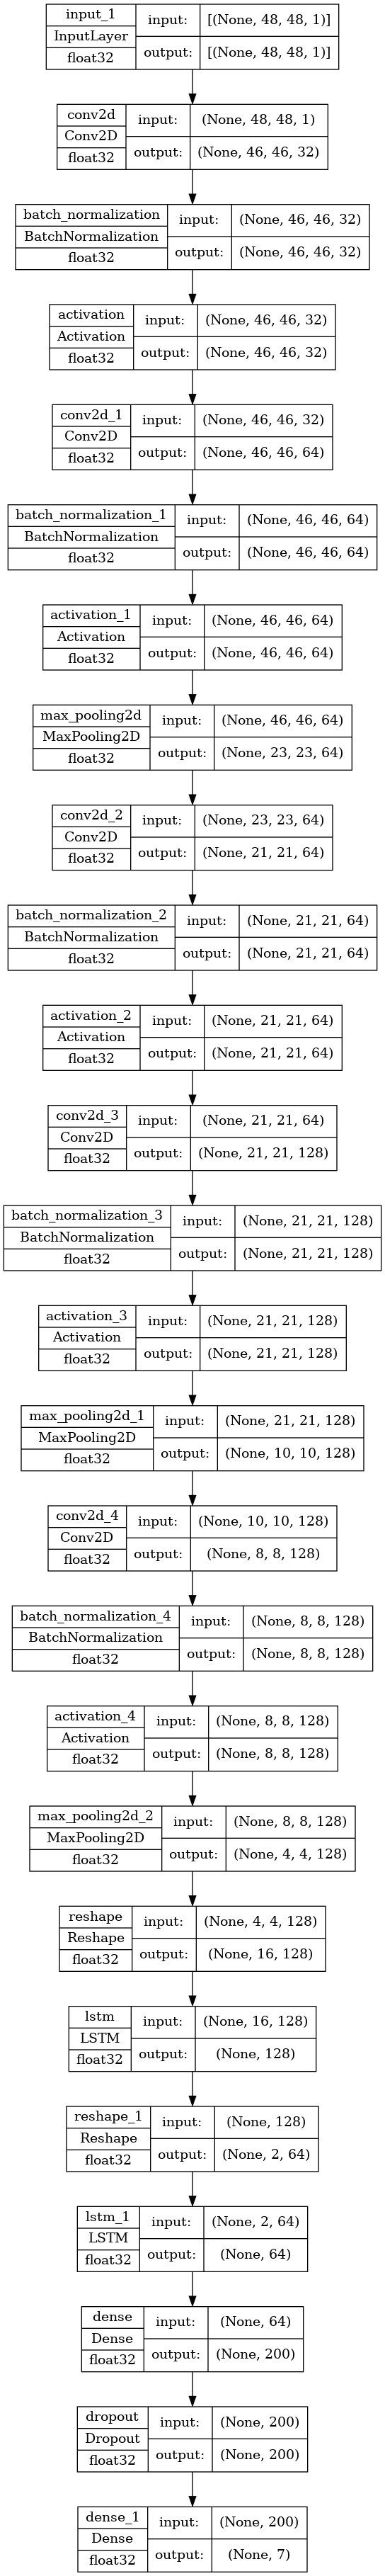

In [37]:
plot_model(model, to_file = "fervi_model.png", show_shapes = True, show_dtype = True)


In [38]:
# Convert an integer target vector y_train into a one-hot encoded matrix.
# 7 is the classes of emotions.
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

y_train = to_categorical(y_train, 7)
y_train.shape


(50724, 7)

In [39]:
# Convert an integer target vector y_train into a one-hot encoded matrix.
# 7 is the classes of emotions.
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

y_valid = to_categorical(y_valid, 7)
y_valid.shape


(6341, 7)

In [40]:
# Convert an integer target vector y_train into a one-hot encoded matrix.
# 7 is the classes of emotions.
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

y_test = to_categorical(y_test, 7)
y_test.shape


(6341, 7)

## 3.5 Train the Model


In [41]:
history_callback_object = model.fit(x=X_train, y=y_train, epochs = 100, callbacks=[early_stopping, reduce_learning_rate], validation_data=(X_valid, y_valid))


Epoch 1/100
1586/1586 [==============================] - 33s 12ms/step - loss: 1.5101 - accuracy: 0.4102 - val_loss: 1.3031 - val_accuracy: 0.5028 - lr: 2.0000e-04
Epoch 2/100
1586/1586 [==============================] - 19s 12ms/step - loss: 1.0761 - accuracy: 0.5864 - val_loss: 1.0915 - val_accuracy: 0.5794 - lr: 2.0000e-04
Epoch 3/100
1586/1586 [==============================] - 19s 12ms/step - loss: 0.9219 - accuracy: 0.6519 - val_loss: 0.9632 - val_accuracy: 0.6333 - lr: 2.0000e-04
Epoch 4/100
1586/1586 [==============================] - 19s 12ms/step - loss: 0.8024 - accuracy: 0.7040 - val_loss: 0.8894 - val_accuracy: 0.6611 - lr: 2.0000e-04
Epoch 5/100
1586/1586 [==============================] - 19s 12ms/step - loss: 0.6927 - accuracy: 0.7504 - val_loss: 0.9092 - val_accuracy: 0.6720 - lr: 2.0000e-04
Epoch 6/100
1586/1586 [==============================] - 19s 12ms/step - loss: 0.5839 - accuracy: 0.7941 - val_loss: 1.1062 - val_accuracy: 0.6392 - lr: 2.0000e-04
Epoch 7/100
1586

## 3.6 Save the history_callback_object


In [42]:
file_path_history_callback_object = "/kaggle/working/trainHistoryDictionary"

with open(file_path_history_callback_object, "wb") as history_callback_object_file:
    pickle.dump(history_callback_object.history, history_callback_object_file)

# This is used to load the history_callback_object whenever necessary.
# with open(file_path_history_callback_object, "rb") as history_callback_object_file:
#     history_callback_object = pickle.load(history_callback_object_file)


## 3.7 Save the Model


In [43]:
file_path_model = "./model.h5"

# Save the architecture and weights of the model.
model.save(file_path_model)


# This is used to load the model whenever necessary.
#file_path_model = "../input/veractpmodel/model.h5"

#model = load_model(file_path_model)


# Save model architecture to JSON.

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5.

model.save_weights("model_weights.h5")
print("The model has been successfully saved. ")


The model has been successfully saved. 


___
## #4 Evaluate Model


## 4.1 Model Loss Graph

### ***NOTE: Remove the .history  after the history_callback_object if you load the history_callback_object from an already existing file. This implies for the two graphs below.***


In [44]:
fig = px.line(data_frame = history_callback_object.history,
              y = ["loss", "val_loss"],
              labels = {"index":"Epoch", "value":"Loss"},
              title = "Loss vs Epoch")
fig.show()

history_callback_object.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

## 4.2 Model Accuracy Graph


In [45]:
fig = px.line(data_frame = history_callback_object.history,
              y = ["accuracy", "val_accuracy"],
              labels = {"index":"Epoch", "value":"Accuracy"},
              title = "Accuracy vs Epoch")
fig.show()

history_callback_object.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

## 4.3 Side to Side Model Loss and Accuracy Graphs


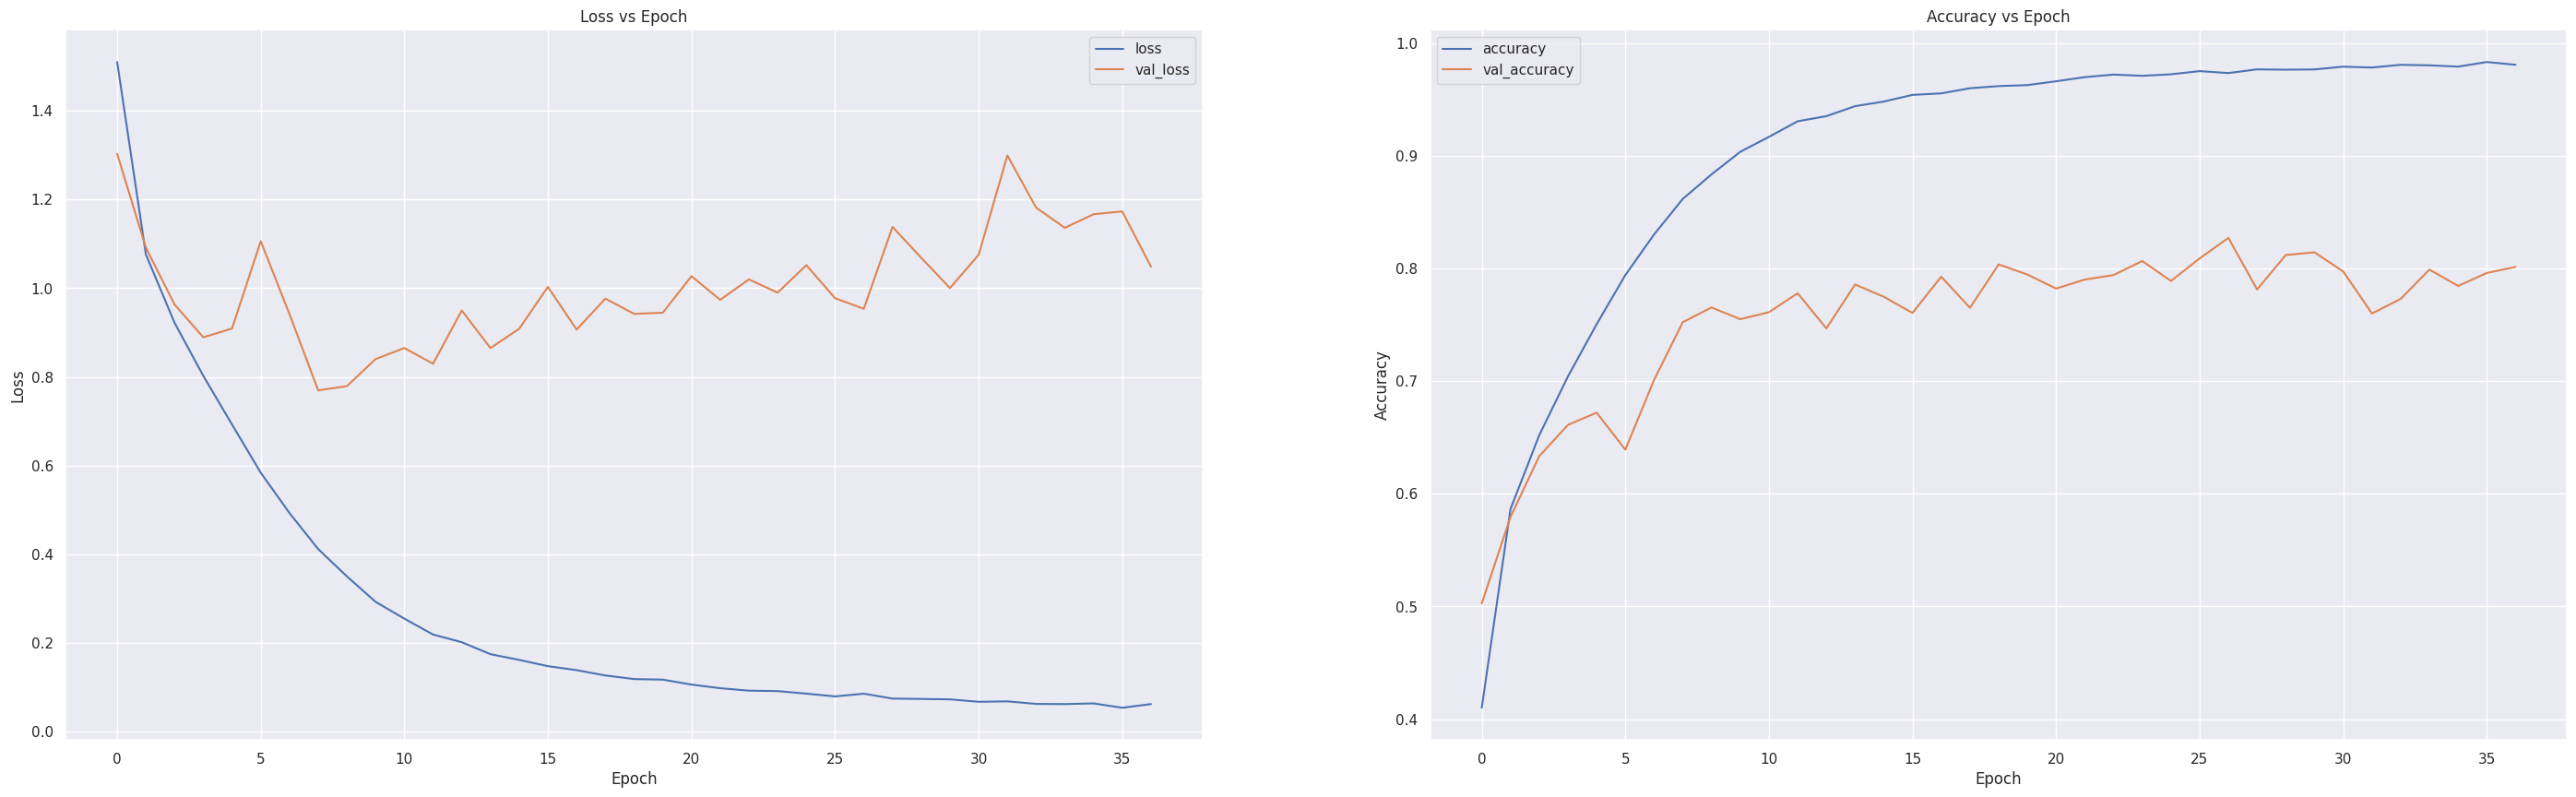

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history["loss"], label = "loss")
ax1.plot(history_callback_object.history["val_loss"], label = "val_loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs Epoch")
ax1.grid(True)

ax2.plot(history_callback_object.history["accuracy"], label = "accuracy")
ax2.plot(history_callback_object.history["val_accuracy"], label = "val_accuracy")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Epoch")
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()


## 4.4 Make and Evaluate New Predictions Using Our Testing Data


In [47]:
# y_pred stores the probabilities for each emotion. The highest probability corresponds to the predicted emotion.
y_pred = model.predict(X_test)
print(y_pred[0])
y_pred


199/199 [==============================] - 2s 4ms/step
[1.4019162e-05 4.0236420e-10 9.9995005e-01 1.4714832e-06 2.2721431e-05
 1.0348712e-05 1.3632820e-06]


array([[1.4019162e-05, 4.0236420e-10, 9.9995005e-01, ..., 2.2721431e-05,
        1.0348712e-05, 1.3632820e-06],
       [3.9722690e-07, 5.3039049e-08, 9.3542971e-04, ..., 1.7614553e-07,
        9.9901998e-01, 8.2738725e-06],
       [7.9167359e-05, 1.7034439e-10, 1.4868178e-06, ..., 2.3227842e-05,
        7.1803180e-07, 2.5813748e-05],
       ...,
       [2.4796461e-06, 1.4013801e-11, 1.7614737e-05, ..., 9.9997687e-01,
        2.0325126e-10, 2.8552151e-06],
       [1.4747289e-03, 1.7837721e-07, 2.9330796e-03, ..., 9.9380833e-01,
        1.3970985e-06, 1.0785202e-03],
       [3.8900562e-06, 2.0143319e-13, 2.7285809e-08, ..., 3.6994251e-08,
        4.0758302e-08, 1.2023816e-07]], dtype=float32)

In [48]:
y_pred = np.argmax(y_pred, axis = 1)
print(y_pred[0])
y_pred


2


array([2, 5, 3, ..., 4, 4, 3])

In [49]:
y_check = np.argmax(y_test, axis = 1)
print(y_check[0])
y_check


2


array([2, 5, 3, ..., 4, 4, 3])

In [50]:
print("Accuracy of model on testing data: ", model.evaluate(X_test, y_test)[1] * 100 , "%", sep = "")


199/199 [==============================] - 1s 5ms/step - loss: 0.9342 - accuracy: 0.8254
Accuracy of model on testing data: 82.54218697547913%


In [51]:
print("Accuracy of model on validation data: ", model.evaluate(X_valid, y_valid)[1] * 100 , "%", sep = "")


199/199 [==============================] - 1s 6ms/step - loss: 0.9537 - accuracy: 0.8270
Accuracy of model on validation data: 82.69988894462585%


In [52]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)

print("Model Test Loss: %f" % (model_loss))
print("Model Test Loss: %f" % (model_loss * 100), "%\n", sep = "")
print("Model Test Accuracy: %f" % (model_accuracy))
print("Model Test Accuracy: %f" % (model_accuracy * 100), "%", sep = "")


199/199 [==============================] - 1s 5ms/step - loss: 0.9342 - accuracy: 0.8254
Model Test Loss: 0.934223
Model Test Loss: 93.422323%

Model Test Accuracy: 0.825422
Model Test Accuracy: 82.542187%


In [53]:
# Calculate our accuracy score.
accuracy = accuracy_score(y_check, y_pred)

# Calculate our precision score.
precision = precision_score(y_check, y_pred, average = "micro")

# Calculate our recall score.
recall = recall_score(y_check, y_pred, average = "micro")

# Calculate our f1-score.
f1 = f1_score(y_check, y_pred, average = "micro")

# Print each of our scores to inspect performance.
print("Accuracy Score: %f" % (accuracy * 100), "%", sep = "")
print("Precision Score: %f" % (precision * 100), "%", sep = "")
print("Recall Score: %f" % (recall * 100), "%", sep = "")
print("F1 Score: %f" % (f1 * 100), "%", sep = "")


Accuracy Score: 82.542186%
Precision Score: 82.542186%
Recall Score: 82.542186%
F1 Score: 82.542186%


## 4.5 Confusion Matrix


[[[5284  149]
  [ 203  705]]

 [[5452    5]
  [   5  879]]

 [[5319  134]
  [ 234  654]]

 [[5260  159]
  [ 182  740]]

 [[5147  304]
  [ 215  675]]

 [[5318   71]
  [  63  889]]

 [[5159  285]
  [ 205  692]]] 



          Angry  Disgust  Fear  Happy  Neutral  Sad  Surprise
Angry       705        3    42     29       64   10        55
Disgust       3      879     0      0        0    1         1
Fear         36        0   654     25       94   35        44
Happy        33        0    17    740       38   13        81
Neutral      34        2    33     48      675    7        91
Sad           6        0    25     15        4  889        13
Surprise     37        0    17     42      104    5       692 



0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



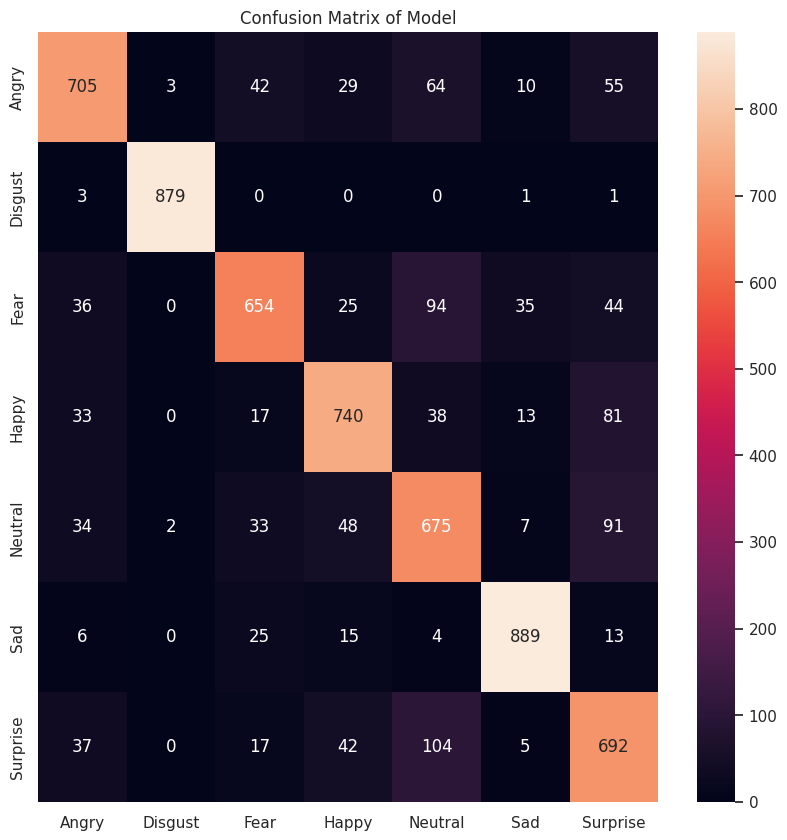

In [54]:
fig = plt.figure(figsize=(10, 10))
plt.title("Confusion Matrix of Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

cm = multilabel_confusion_matrix(y_check, y_pred)
print(cm, "\n\n\n")

model_matrix = confusion_matrix(y_check, y_pred)
cm = pd.DataFrame(model_matrix,
                  index = [i for i in emotions_classes_label],
                  columns = [i for i in emotions_classes_label]
                 )


ax = sns.heatmap(cm,
                 annot = True,
                 fmt = "d",cbar=True)

print(cm, "\n\n\n")

print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")

plt.show()


## 4.6 Classification Report


In [55]:
y_pred = model.predict(X_test)
y_result = []
y_actual = []

for pred in y_pred:
    y_result.append(np.argmax(pred))

for pred in y_test:
    y_actual.append(np.argmax(pred))


199/199 [==============================] - 1s 4ms/step


In [56]:
print("Model Classification Report\n", classification_report(y_actual, y_result))


Model Classification Report
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       908
           1       0.99      0.99      0.99       884
           2       0.83      0.74      0.78       888
           3       0.82      0.80      0.81       922
           4       0.69      0.76      0.72       890
           5       0.93      0.93      0.93       952
           6       0.71      0.77      0.74       897

    accuracy                           0.83      6341
   macro avg       0.83      0.82      0.83      6341
weighted avg       0.83      0.83      0.83      6341



## 4.7 Display Images


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral



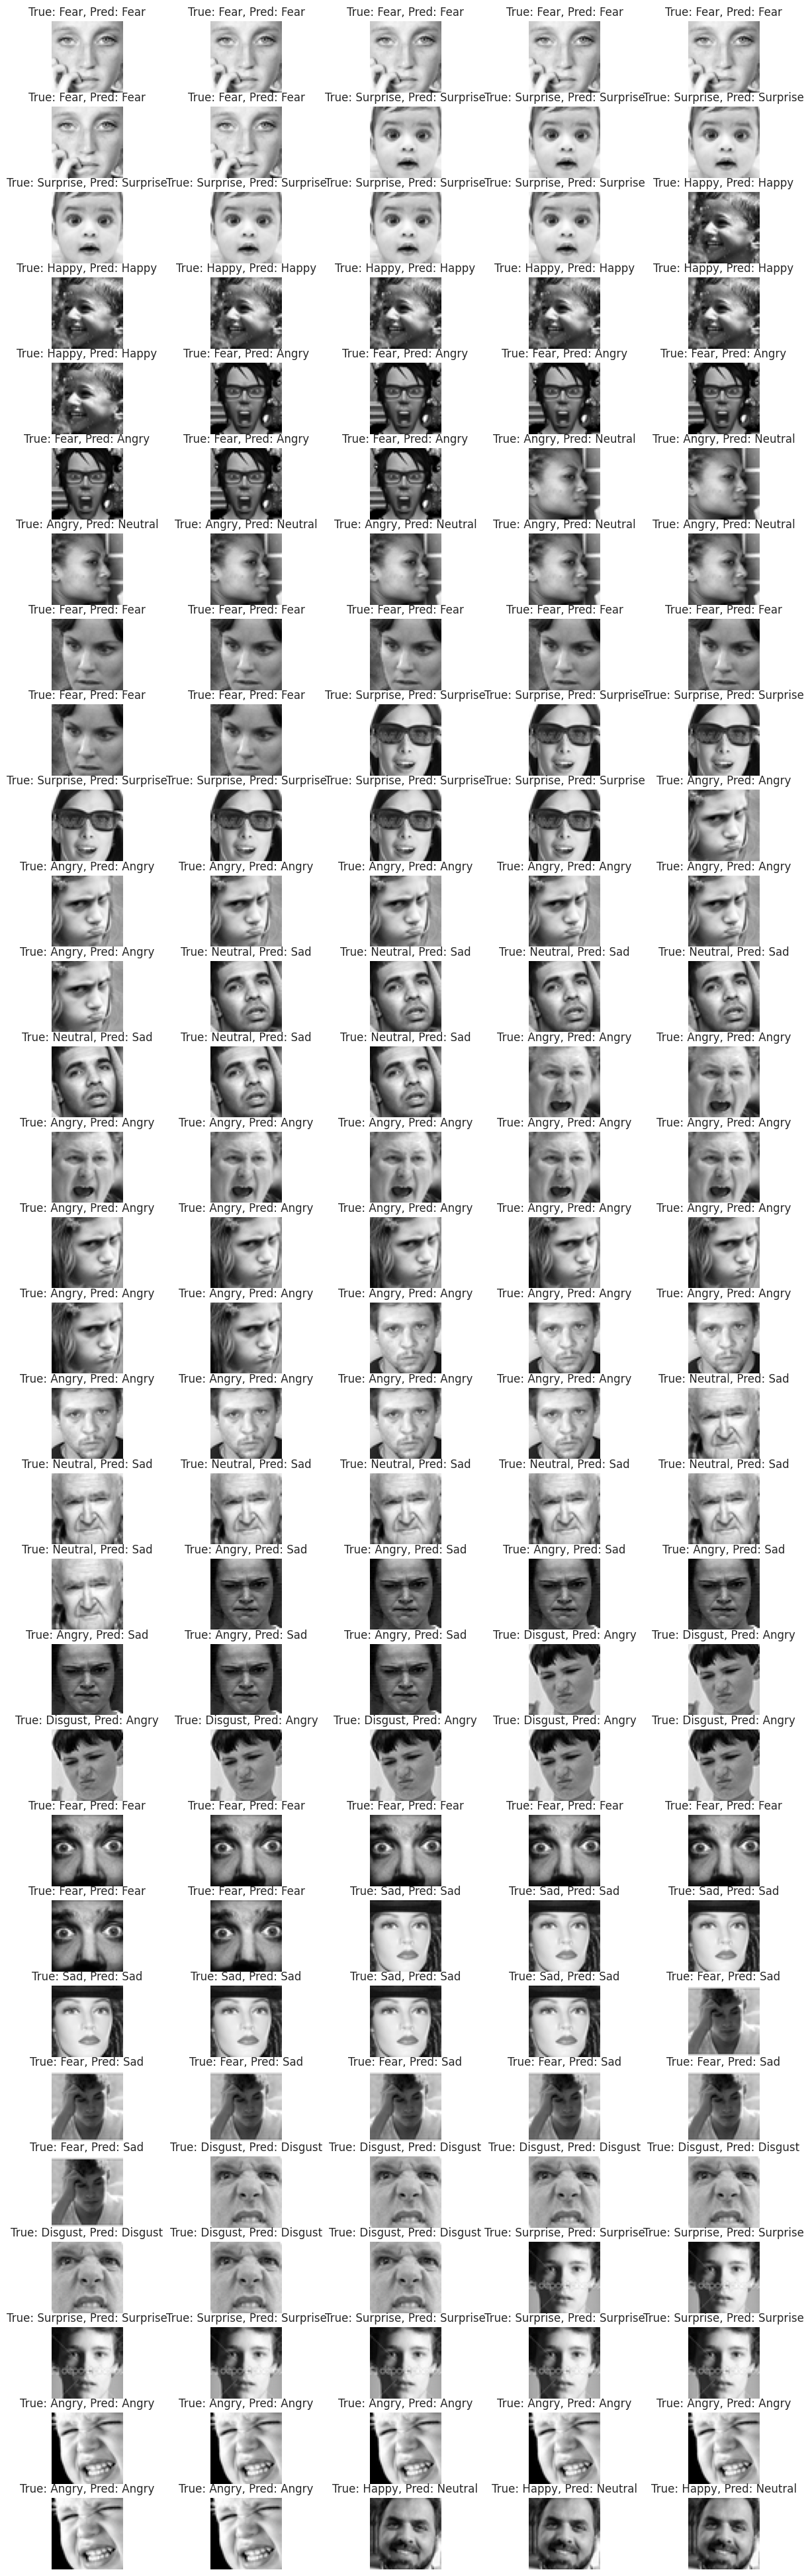

In [57]:
print("0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral\n")


def display_images(images, true_labels, pred_labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 50))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            true = np.argmax(true_labels[i])
            pred = np.argmax(pred_labels[i])
            ax.set_title(f"True: {emotions_classes_dict[true]}, Pred: {emotions_classes_dict[pred]}")
        ax.axis('off')
    

# Find indices of misclassified images.

misclassified_indices = np.where(y_pred != y_test)[0]

# Display the first 16 misclassified images

display_images(X_test[misclassified_indices], y_test[misclassified_indices], y_pred[misclassified_indices], 30, 5)

plt.show()
